In [1]:
import os
# import drjit
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sionna
import tensorflow as tf
import pickle
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
tf.get_logger().setLevel('ERROR')
tf.config.run_functions_eagerly(True)

from jammer.simulation_model import *
from jammer.utils import *
import jammer.simulation_model as sim
from tensorflow.python.keras.losses import MeanAbsoluteError, MeanSquaredError, BinaryCrossentropy

## Weight Grid

This is the training code and display code for the unmitigated weight grid

In [2]:
# model_parameters = {}
# jammer_parameters = {}
# model_parameters["perfect_csi"] = False
# model_parameters["jammer_present"] = True
# model_parameters["num_silent_pilot_symbols"] = 0
# jammer_parameters["trainable"] = True
# model_parameters["jammer_parameters"] = jammer_parameters
# jammer_parameters["trainable_mask"] = tf.ones([14, 1], dtype=tf.bool)
# 
# sim.BATCH_SIZE = 2
# 
# # massive grid: training with different jammer power and different number of UEs
# num_ut = range(1, 9)
# jammer_power = [db_to_linear(x) for x in np.arange(-2.5, 15.1, 2.5, dtype=np.float32)]
# parameters = [(x, y) for x in num_ut for y in jammer_power]
# n, p = parameters[parameter_num]
# model_parameters["num_ut"] = n
# model_parameters["jammer_power"] = p
# model_parameters["num_ofdm_symbols"] = 14
# model_parameters["fft_size"] = 64
# model_parameters["num_bs_ant"] = 24
# jammer_parameters["trainable_mask"] = tf.ones([14, 1], dtype=tf.bool)
# model = Model(**model_parameters)
# train_model(model,
#             loss_fn=negative_function(MeanAbsoluteError()),
#             loss_over_logits=False,
#             weights_filename=f"weights/unmitigated/grid/ue_{n}_power_{linear_to_db(p):.1f}dB.pickle",
#             log_tensorboard=True,
#             log_weight_images=True,
#             show_final_weights=False,
#             num_iterations=2000,
#             ebno_db=2.5)

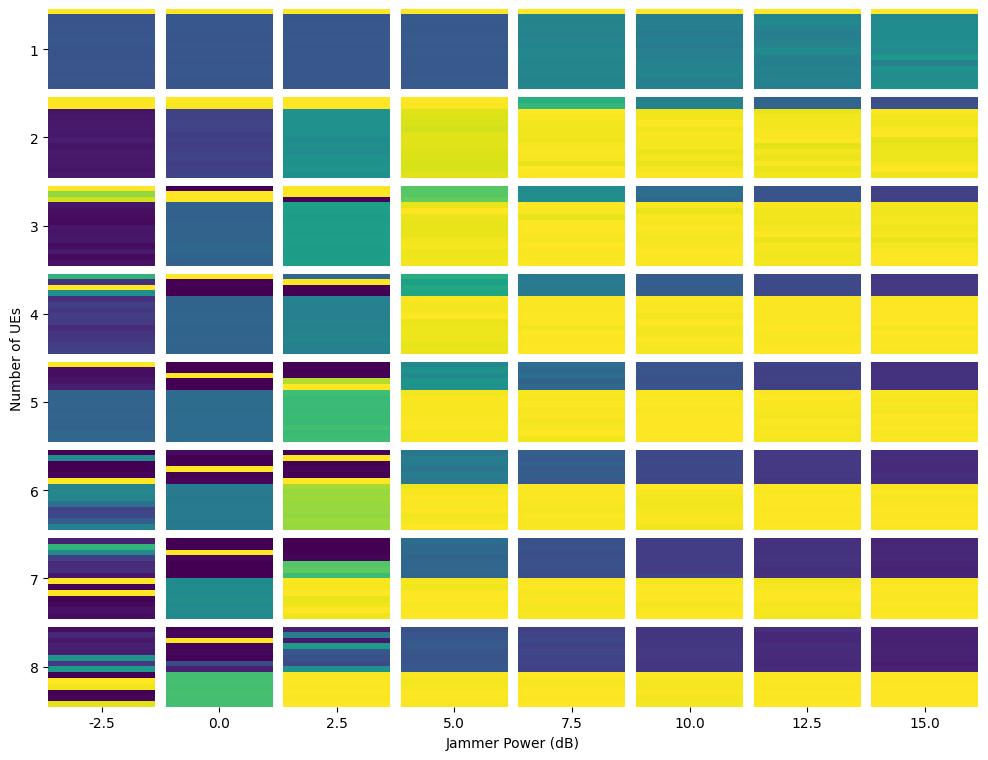

In [3]:
plt.figure(figsize=(10, 7.5))
num_ut = range(1, 9)
jammer_power = np.arange(-2.5, 15.1, 2.5, dtype=np.float32)
bers = np.zeros([len(num_ut), len(jammer_power)])
for i in range(len(num_ut)):
    for j in range(len(jammer_power)):
        n = num_ut[i]
        p = jammer_power[j]
        filename = f"weights/unmitigated/grid/ue_{n}_power_{p}dB.pickle"
        with open(filename, 'rb') as f:
            weights = pickle.load(f)[1]
        weights = NonNegMaxMeanSquareNorm()(weights)
        plt.subplot(len(num_ut), len(jammer_power), i * len(jammer_power) + j + 1)
        plt.axis('off')
        # plt.imshow(weights, aspect='auto')
        plt.imshow(weights, aspect='auto', vmin=0)

# parameters: space between plots
wspace = 0.1
hspace = 0.1
m = len(num_ut)
n = len(jammer_power)
plt.subplots_adjust(bottom=0.07, top=1.0, left=0.07, right=1.0, wspace=wspace, hspace=hspace)
# labels on the x and y plots-axis
ax = plt.gcf().add_axes([0.07, 0.07, 0.93, 0.93], frameon=False)
plot_width = 1.0 / (n + (n - 1) * wspace)
gap_width = wspace * plot_width
ax.set_xticks(np.arange(plot_width / 2, 1.0, gap_width + plot_width), labels=jammer_power)
ax.set_xlabel("Jammer Power (dB)")
ax.invert_yaxis()
plot_height = 1.0 / (m + (m - 1) * hspace)
gap_height = hspace * plot_height
ax.set_yticks(plot_height / 2 + np.arange(m) * (gap_height + plot_height), labels=num_ut)
ax.set_ylabel("Number of UEs")

plt.show()

## Simple Jammer Result

First demonstration: Unjammed vs Jammed(unmitigated) vs Jammed(POS)

In [11]:
ber_plots.reset()
model_parameters = {}
jammer_parameters = {}
model_parameters["num_ut"] = 1
model_parameters["perfect_csi"] = False
model_parameters["num_silent_pilot_symbols"] = 4
jammer_parameters["num_tx_ant"] = 2
model_parameters["jammer_parameters"] = jammer_parameters
sim.BATCH_SIZE = 256
sim.MAX_MC_ITER = 50
sim.ebno_dbs = np.linspace(-5., 15., 10)
# sim.ebno_dbs = np.linspace(-5., 15., 21)

ber_plots.reset()
model = Model(**model_parameters)
simulate_model(model, "No Jammer")

model_parameters["perfect_jammer_csi"] = False
model_parameters["jammer_present"] = True
model_parameters["jammer_power"] = db_to_linear(10.)
model_parameters["jammer_mitigation"] = "pos"
model_parameters["jammer_mitigation_dimensionality"] = 2
model = Model(**model_parameters)
simulate_model(model, "Jammer, POS")

model_parameters["jammer_mitigation_dimensionality"] = 1
model = Model(**model_parameters)
simulate_model(model, "Jammer, POS, 1D Nulling")

model_parameters["jammer_mitigation"] = None
model = Model(**model_parameters)
simulate_model(model, "Jammer, unmigitated")

ber_plots.title = "Simple Jammer Mitigation: Est. CSI, 1 UE, 1x2 Jammer (10 dB/Ant)"
ber_plots(ylim=(1e-5, 1))
with open("bers/simple_pos.pickle", 'wb') as f:
    bers = pickle.dump(ber_plots, f)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 4.0282e-02 | 1.0000e+00 |     1187957 |    29491200 |        12800 |       12800 |        19.4 |reached max iter       
   -2.778 | 7.6054e-03 | 1.0000e+00 |      224293 |    29491200 |        12800 |       12800 |        19.6 |reached max iter       
   -0.556 | 7.9352e-04 | 4.9508e-01 |       23402 |    29491200 |         6337 |       12800 |        19.6 |reached max iter       
    1.667 | 8.7925e-05 | 6.1719e-02 |        2593 |    29491200 |          790 |       12800 |        19.4 |reached max iter       
    3.889 | 7.5616e-06 | 8.4375e-03 |         223 |    29491200 |          108 |       12800 |        19.3 |reached max iter       
    6.111 | 5.7644e-07 | 6.2500e-04 |          17 |    29491200 |            8 |     

Now we add some velocity (0km/h, 20km/h, 120km/h). Compared with unmitigated jammer.

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 4.7141e-01 | 1.0000e+00 |   139024538 |   294912000 |       128000 |      128000 |       272.5 |reached max iter       
     -4.0 | 4.7145e-01 | 1.0000e+00 |   139035615 |   294912000 |       128000 |      128000 |       273.6 |reached max iter       
     -3.0 | 4.7139e-01 | 1.0000e+00 |   139018940 |   294912000 |       128000 |      128000 |       274.4 |reached max iter       
     -2.0 | 4.7133e-01 | 1.0000e+00 |   139002026 |   294912000 |       128000 |      128000 |       274.6 |reached max iter       
     -1.0 | 4.7131e-01 | 1.0000e+00 |   138994819 |   294912000 |       128000 |      128000 |       272.5 |reached max iter       
      0.0 | 4.7124e-01 | 1.0000e+00 |   138975380 |   294912000 |       128000 |     

FileNotFoundError: [Errno 2] No such file or directory: 'bers/simple_pos_mobility.pickle'

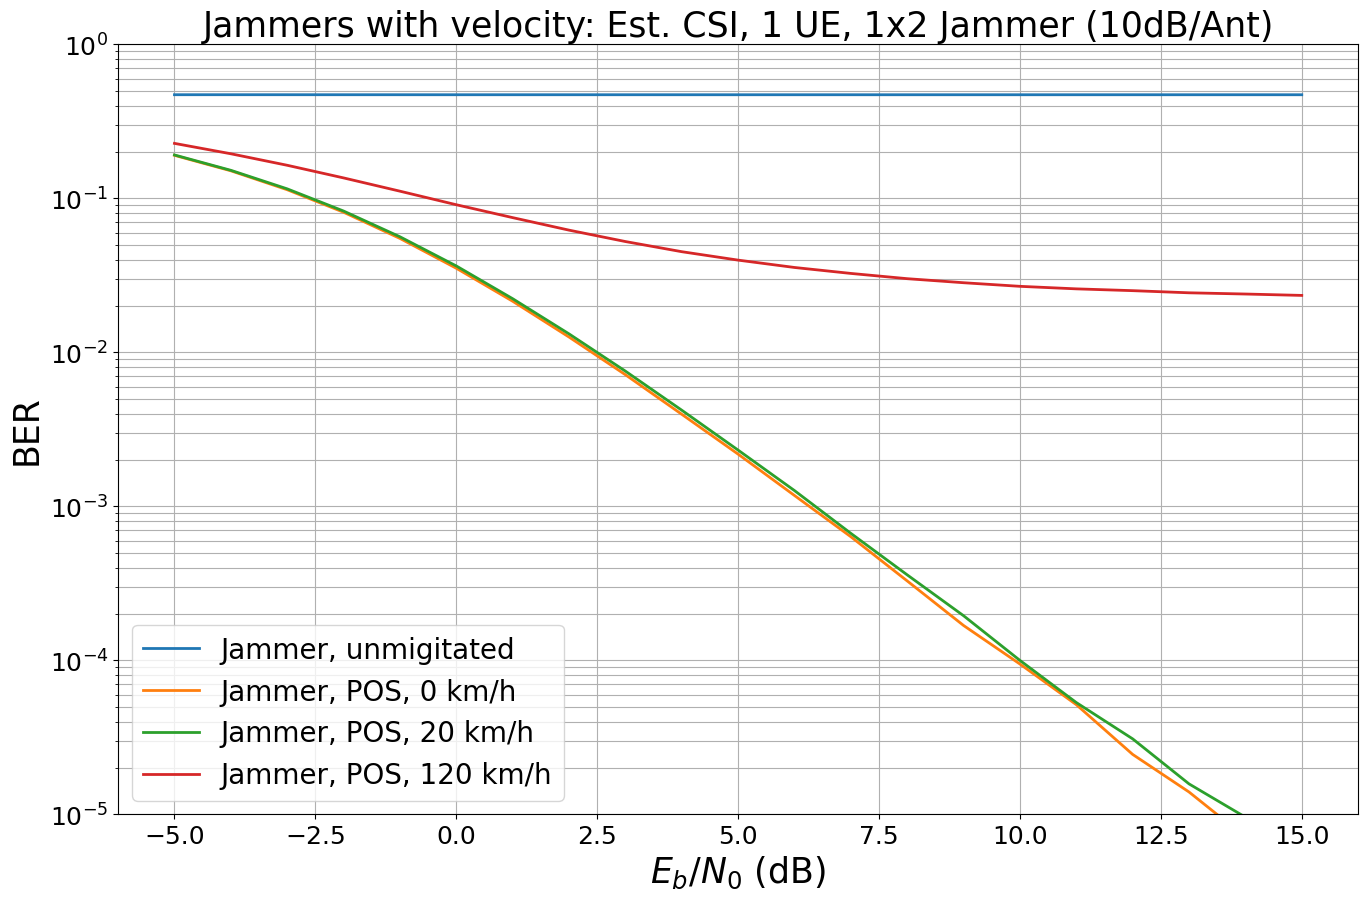

In [5]:
ber_plots.reset()
model_parameters = {}
jammer_parameters = {}
model_parameters["jammer_parameters"] = jammer_parameters
model_parameters["num_ut"] = 1
model_parameters["perfect_csi"] = False
model_parameters["perfect_jammer_csi"] = False
model_parameters["num_silent_pilot_symbols"] = 4
jammer_parameters["num_tx_ant"] = 2
model_parameters["jammer_present"] = True
model_parameters["jammer_power"] = db_to_linear(10.)
sim.BATCH_SIZE = 256
sim.MAX_MC_ITER = 500
sim.ebno_dbs = np.linspace(-5., 15., 21)

model = Model(**model_parameters)
simulate_model(model, "Jammer, unmigitated, 0km/h")

model_parameters["jammer_mitigation"] = "pos"
model_parameters["jammer_mitigation_dimensionality"] = 2
kmhs = [0, 20, 120]
for kmh in kmhs:
    meter_per_second = kmh / 3.6
    model_parameters["min_ut_velocity"] = meter_per_second
    model_parameters["max_ut_velocity"] = meter_per_second
    model_parameters["min_jammer_velocity"] = meter_per_second
    model_parameters["max_jammer_velocity"] = meter_per_second
    model = Model(**model_parameters)
    simulate_model(model, f"Jammer, POS, {kmh} km/h")

ber_plots.title = "Jammers with velocity: Est. CSI, 1 UE, 1x2 Jammer (10dB/Ant)"
ber_plots(ylim=(1e-5, 1))
with open("bers/simple_pos_mobility.pickle", 'wb') as f:
    bers = pickle.dump(ber_plots, f)

## Time Domain Simulation

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 6.7796e-02 | 1.0000e+00 |       58315 |      860160 |          280 |         280 |        24.1 |reached max iter       
   -2.778 | 3.0708e-02 | 1.0000e+00 |       26414 |      860160 |          280 |         280 |        24.5 |reached max iter       
   -0.556 | 9.9028e-03 | 1.0000e+00 |        8518 |      860160 |          280 |         280 |        24.5 |reached max iter       
    1.667 | 2.9355e-03 | 9.2857e-01 |        2525 |      860160 |          260 |         280 |        24.2 |reached max iter       
    3.889 | 6.2314e-04 | 4.9643e-01 |         536 |      860160 |          139 |         280 |        23.9 |reached max iter       
    6.111 | 1.2091e-04 | 1.3929e-01 |         104 |      860160 |           39 |     

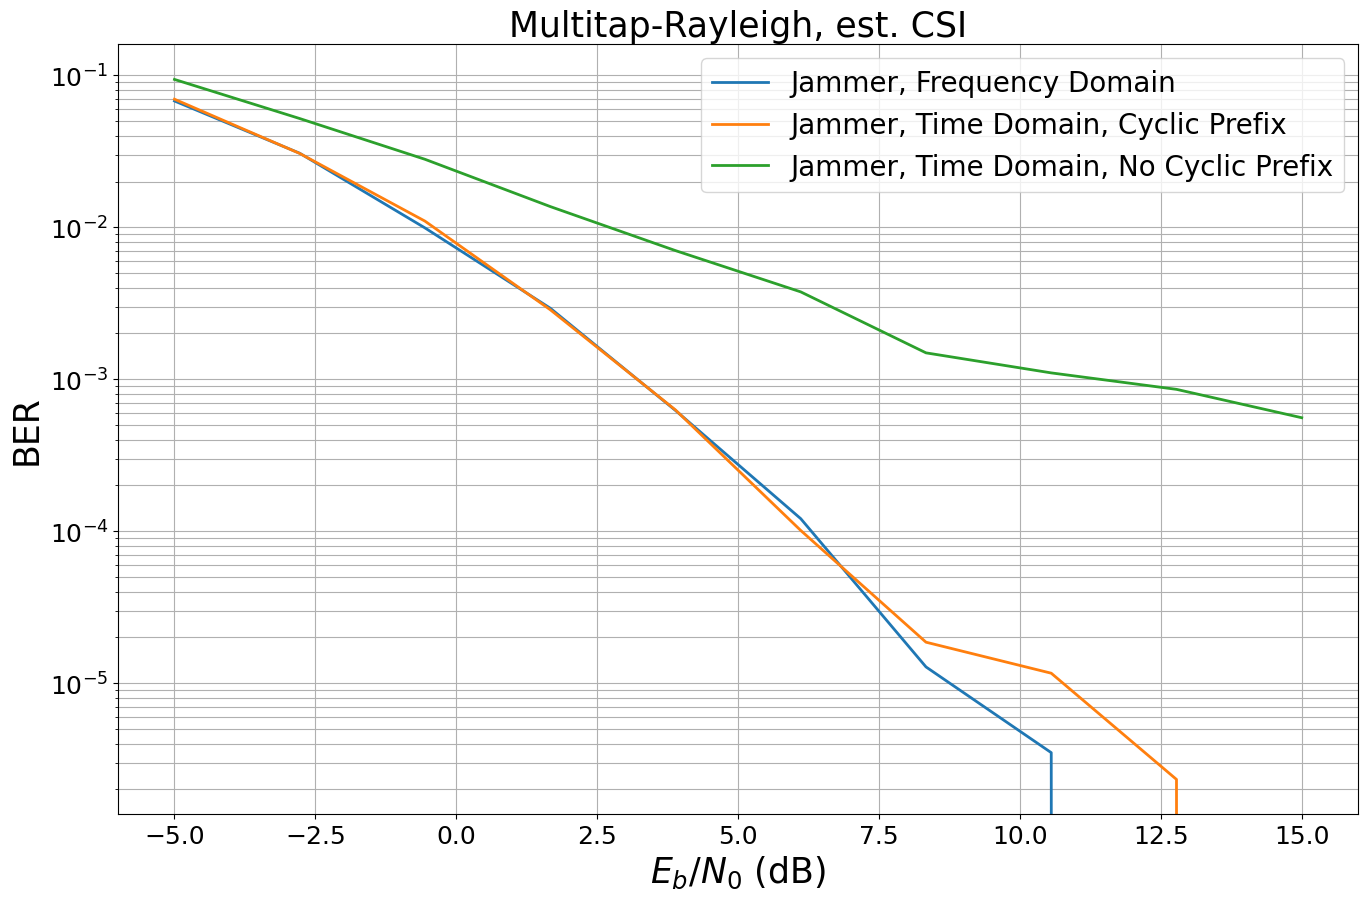

In [14]:
# 1. Multitap-Rayleigh, est. CSI
# 2. UMi, NR-Compliant (2.3us CP), est. CSI
ber_plots.reset()
model_parameters = {}
jammer_parameters = {}
model_parameters["jammer_parameters"] = jammer_parameters
model_parameters["num_ut"] = 6
model_parameters["perfect_csi"] = False
model_parameters["perfect_jammer_csi"] = False
model_parameters["num_silent_pilot_symbols"] = 6
model_parameters["jammer_present"] = True
model_parameters["jammer_power"] = db_to_linear(20.)
model_parameters["jammer_mitigation"] = "ian"
model_parameters["scenario"] = "umi"
model_parameters["cyclic_prefix_length"] = 50
# model_parameters["jammer_mitigation_dimensionality"] = 3
sim.BATCH_SIZE = 4
# sim.MAX_MC_ITER = 70
# sim.ebno_dbs = np.linspace(-5., 15., 10)
sim.MAX_MC_ITER = 700
sim.ebno_dbs = np.linspace(-5., 15., 21)

model = Model(**model_parameters)
simulate_model(model, "Jammer, Frequency Domain")

model_parameters["domain"] = "time"
jammer_parameters["send_cyclic_prefix"] = True
model = Model(**model_parameters)
simulate_model(model, "Jammer, Time Domain, Cyclic Prefix")

jammer_parameters["send_cyclic_prefix"] = False
model = Model(**model_parameters)
simulate_model(model, "Jammer, Time Domain, No Cyclic Prefix")

ber_plots.title = "Multitap-Rayleigh, est. CSI, Jammer (20dB), 6D Nulled"
ber_plots()
with open("bers/time_pos_rayleigh.pickle", 'wb') as f:
    bers = pickle.dump(ber_plots, f)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 7.1173e-03 | 1.0000e+00 |        6122 |      860160 |          280 |         280 |        24.2 |reached max iter       
   -2.778 | 1.8055e-03 | 8.8929e-01 |        1553 |      860160 |          249 |         280 |        23.9 |reached max iter       
   -0.556 | 2.9413e-04 | 3.9286e-01 |         253 |      860160 |          110 |         280 |        24.3 |reached max iter       
    1.667 | 3.8365e-05 | 9.6429e-02 |          33 |      860160 |           27 |         280 |        24.0 |reached max iter       
    3.889 | 1.3951e-05 | 2.5000e-02 |          12 |      860160 |            7 |         280 |        24.3 |reached max iter       
    6.111 | 1.1626e-06 | 3.5714e-03 |           1 |      860160 |            1 |     

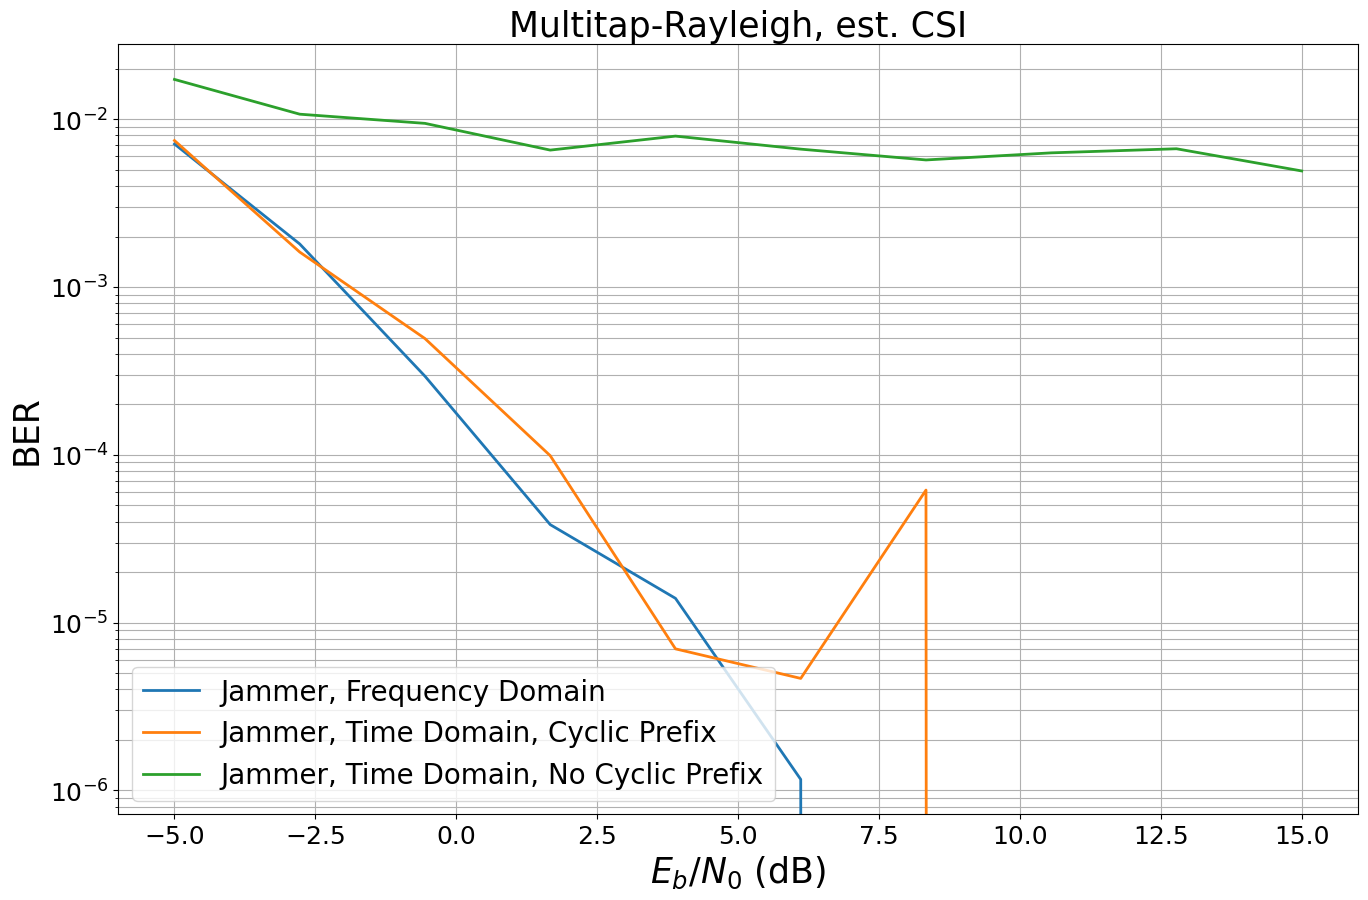

In [15]:
# 1. Multitap-Rayleigh, est. CSI
# 2. UMi, NR-Compliant (2.3us CP), est. CSI
ber_plots.reset()
model_parameters = {}
jammer_parameters = {}
model_parameters["jammer_parameters"] = jammer_parameters
model_parameters["num_ut"] = 6
model_parameters["perfect_csi"] = True
model_parameters["perfect_jammer_csi"] = True
model_parameters["num_silent_pilot_symbols"] = 6
model_parameters["jammer_present"] = True
model_parameters["jammer_power"] = db_to_linear(20.)
model_parameters["jammer_mitigation"] = "ian"
model_parameters["scenario"] = "umi"
model_parameters["cyclic_prefix_length"] = 100
# model_parameters["jammer_mitigation_dimensionality"] = 3
sim.BATCH_SIZE = 4
# sim.MAX_MC_ITER = 70
# sim.ebno_dbs = np.linspace(-5., 15., 10)
sim.MAX_MC_ITER = 700
sim.ebno_dbs = np.linspace(-5., 15., 21)

model = Model(**model_parameters)
simulate_model(model, "Jammer, Frequency Domain")

model_parameters["domain"] = "time"
jammer_parameters["send_cyclic_prefix"] = True
model = Model(**model_parameters)
simulate_model(model, "Jammer, Time Domain, Cyclic Prefix")

jammer_parameters["send_cyclic_prefix"] = False
model = Model(**model_parameters)
simulate_model(model, "Jammer, Time Domain, No Cyclic Prefix")

ber_plots.title = "UMi, est. CSI, Jammer (20dB), 6D Nulled"
ber_plots()
with open("bers/time_pos_umi.pickle", 'wb') as f:
    bers = pickle.dump(ber_plots, f)

#### Jammer Singular Values

## Coded Jammer Training

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 6.7619e-02 | 9.8109e-01 |     1329449 |    19660800 |         6279 |        6400 |        48.7 |reached max iter       
   -2.778 | 2.8069e-02 | 7.3531e-01 |      551866 |    19660800 |         4706 |        6400 |        48.5 |reached max iter       
   -0.556 | 1.6479e-02 | 5.5469e-01 |      323991 |    19660800 |         3550 |        6400 |        48.7 |reached max iter       
    1.667 | 1.5777e-02 | 5.6063e-01 |      310195 |    19660800 |         3588 |        6400 |        48.6 |reached max iter       
    3.889 | 1.7792e-02 | 6.3844e-01 |      349801 |    19660800 |         4086 |        6400 |        48.5 |reached max iter       
    6.111 | 2.0446e-02 | 6.9641e-01 |      401989 |    19660800 |         4457 |     

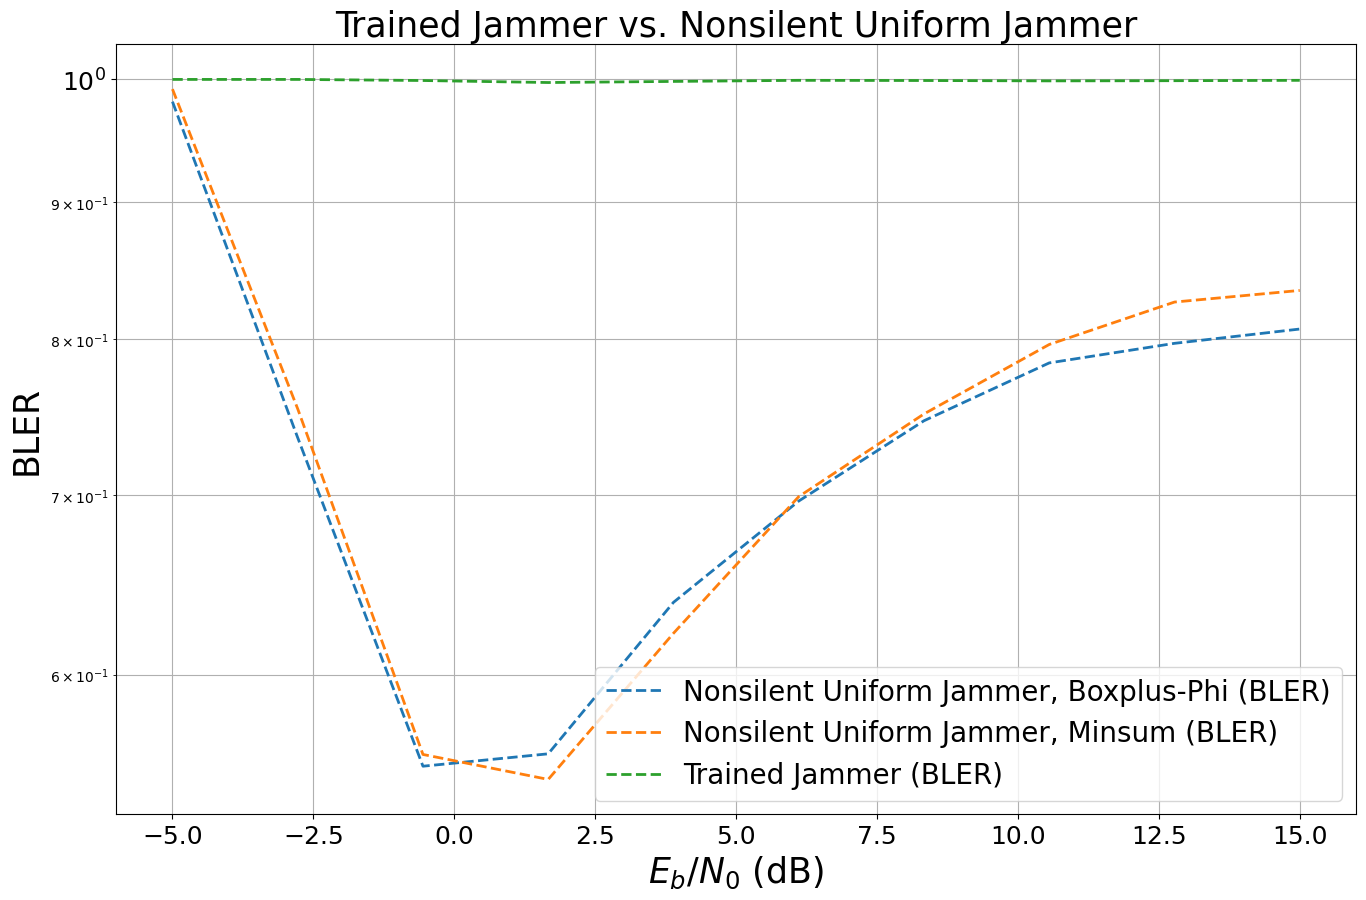

In [17]:
# noch einen Plot mit Minsum
ber_plots.reset()
# common parameters
model_parameters = {}
jammer_parameters = {}
decoder_parameters={}
model_parameters["perfect_csi"] = False
model_parameters["num_ut"] = 4
model_parameters["jammer_present"] = True
model_parameters["jammer_mitigation"] = "pos"
model_parameters["jammer_mitigation_dimensionality"] = 1
model_parameters["num_silent_pilot_symbols"] = 4
model_parameters["coderate"] = 0.5
jammer_parameters["trainable"] = False
jammer_parameters["trainable_mask"] = tf.ones([14, 1], dtype=tf.bool)
decoder_parameters["num_iter"] = 8
decoder_parameters["cn_type"] = "boxplus-phi"
model_parameters["jammer_parameters"] = jammer_parameters
model_parameters["decoder_parameters"] = decoder_parameters
sim.BATCH_SIZE = 128
sim.MAX_MC_ITER = 50
sim.ebno_dbs = np.linspace(-5., 15., 10)
# sim.MAX_MC_ITER = 200
# sim.ebno_dbs = np.linspace(-5., 15., 21)

jammer_power = 1.0
model_parameters["jammer_power"] = jammer_power * normalize_power(tf.concat([tf.zeros([4,1]), tf.ones([10,1])], axis=0))

# Nonsilent Uniform jammer
model = Model(**model_parameters)
simulate_model(model, "Nonsilent Uniform Jammer, Boxplus-Phi", add_bler=True)

# Nonsilent Uniform jammer with Minsum
decoder_parameters["cn_type"] = "minsum"
model = Model(**model_parameters)
simulate_model(model, "Nonsilent Uniform Jammer, Minsum", add_bler=True)

# Trained jammer
model_parameters["jammer_power"] = jammer_power
model = Model(**model_parameters)
load_weights(model, "weights/coded/symbol/iteration_loss_2/ue_4_alpha_0.5_exp_False_8_iter.pickle")
simulate_model(model, "Trained Jammer", add_bler=True)

ber_plots.title = "Trained Jammer vs. Nonsilent Uniform Jammer"
ber_plots(show_ber=False)
# with open("bers/coded_bler.pickle", 'wb') as f:
#     bers = pickle.dump(ber_plots, f)

## 